Import Libraries

In [4]:
import pandas as pd
import geopandas as gp
import matplotlib
import matplotlib.pyplot as plt
import requests
import os
import fiona
import numpy as np
import shapely
from datetime import datetime
from shapely.geometry import Point

Convert data stored in .csv files in cwd into dictionary objects

In [75]:
listings = pd.read_csv("listings.csv")
review = pd.read_csv("reviews.csv")
neighbourhoods = pd.read_csv("neighbourhoods.csv")

Creating map given with neighbourhoods.geojson

In [8]:
# Stores geo data
suburbs = gp.read_file("neighbourhoods.geojson")


# Scales map plot size
%matplotlib inline

# Updates matplotlib fontsize
plt.rcParams.update({'font.size': 22})

# Updates matplotlib graph display size
plt.rcParams['figure.figsize'] = (35, 50)

In [9]:
# Adds a centroid / small circle in the middle of a geometry shape
# Necessary to plot location names in the map
def add_centroid(row):
    return row.geometry.centroid

In [10]:
# Function to add a geometry column into listings 
# storing a Shapely Point
def newGeometry(data_list):
    geo_list = []

    for x in range(len(data_list["longitude"])):
        point = Point(data_list["longitude"][x], data_list["latitude"][x])
        geo_list.append(point)

    data_list["geometry"] = geo_list;

    return data_list

Text(0.5, 0.8, 'NSW Suburb Map')

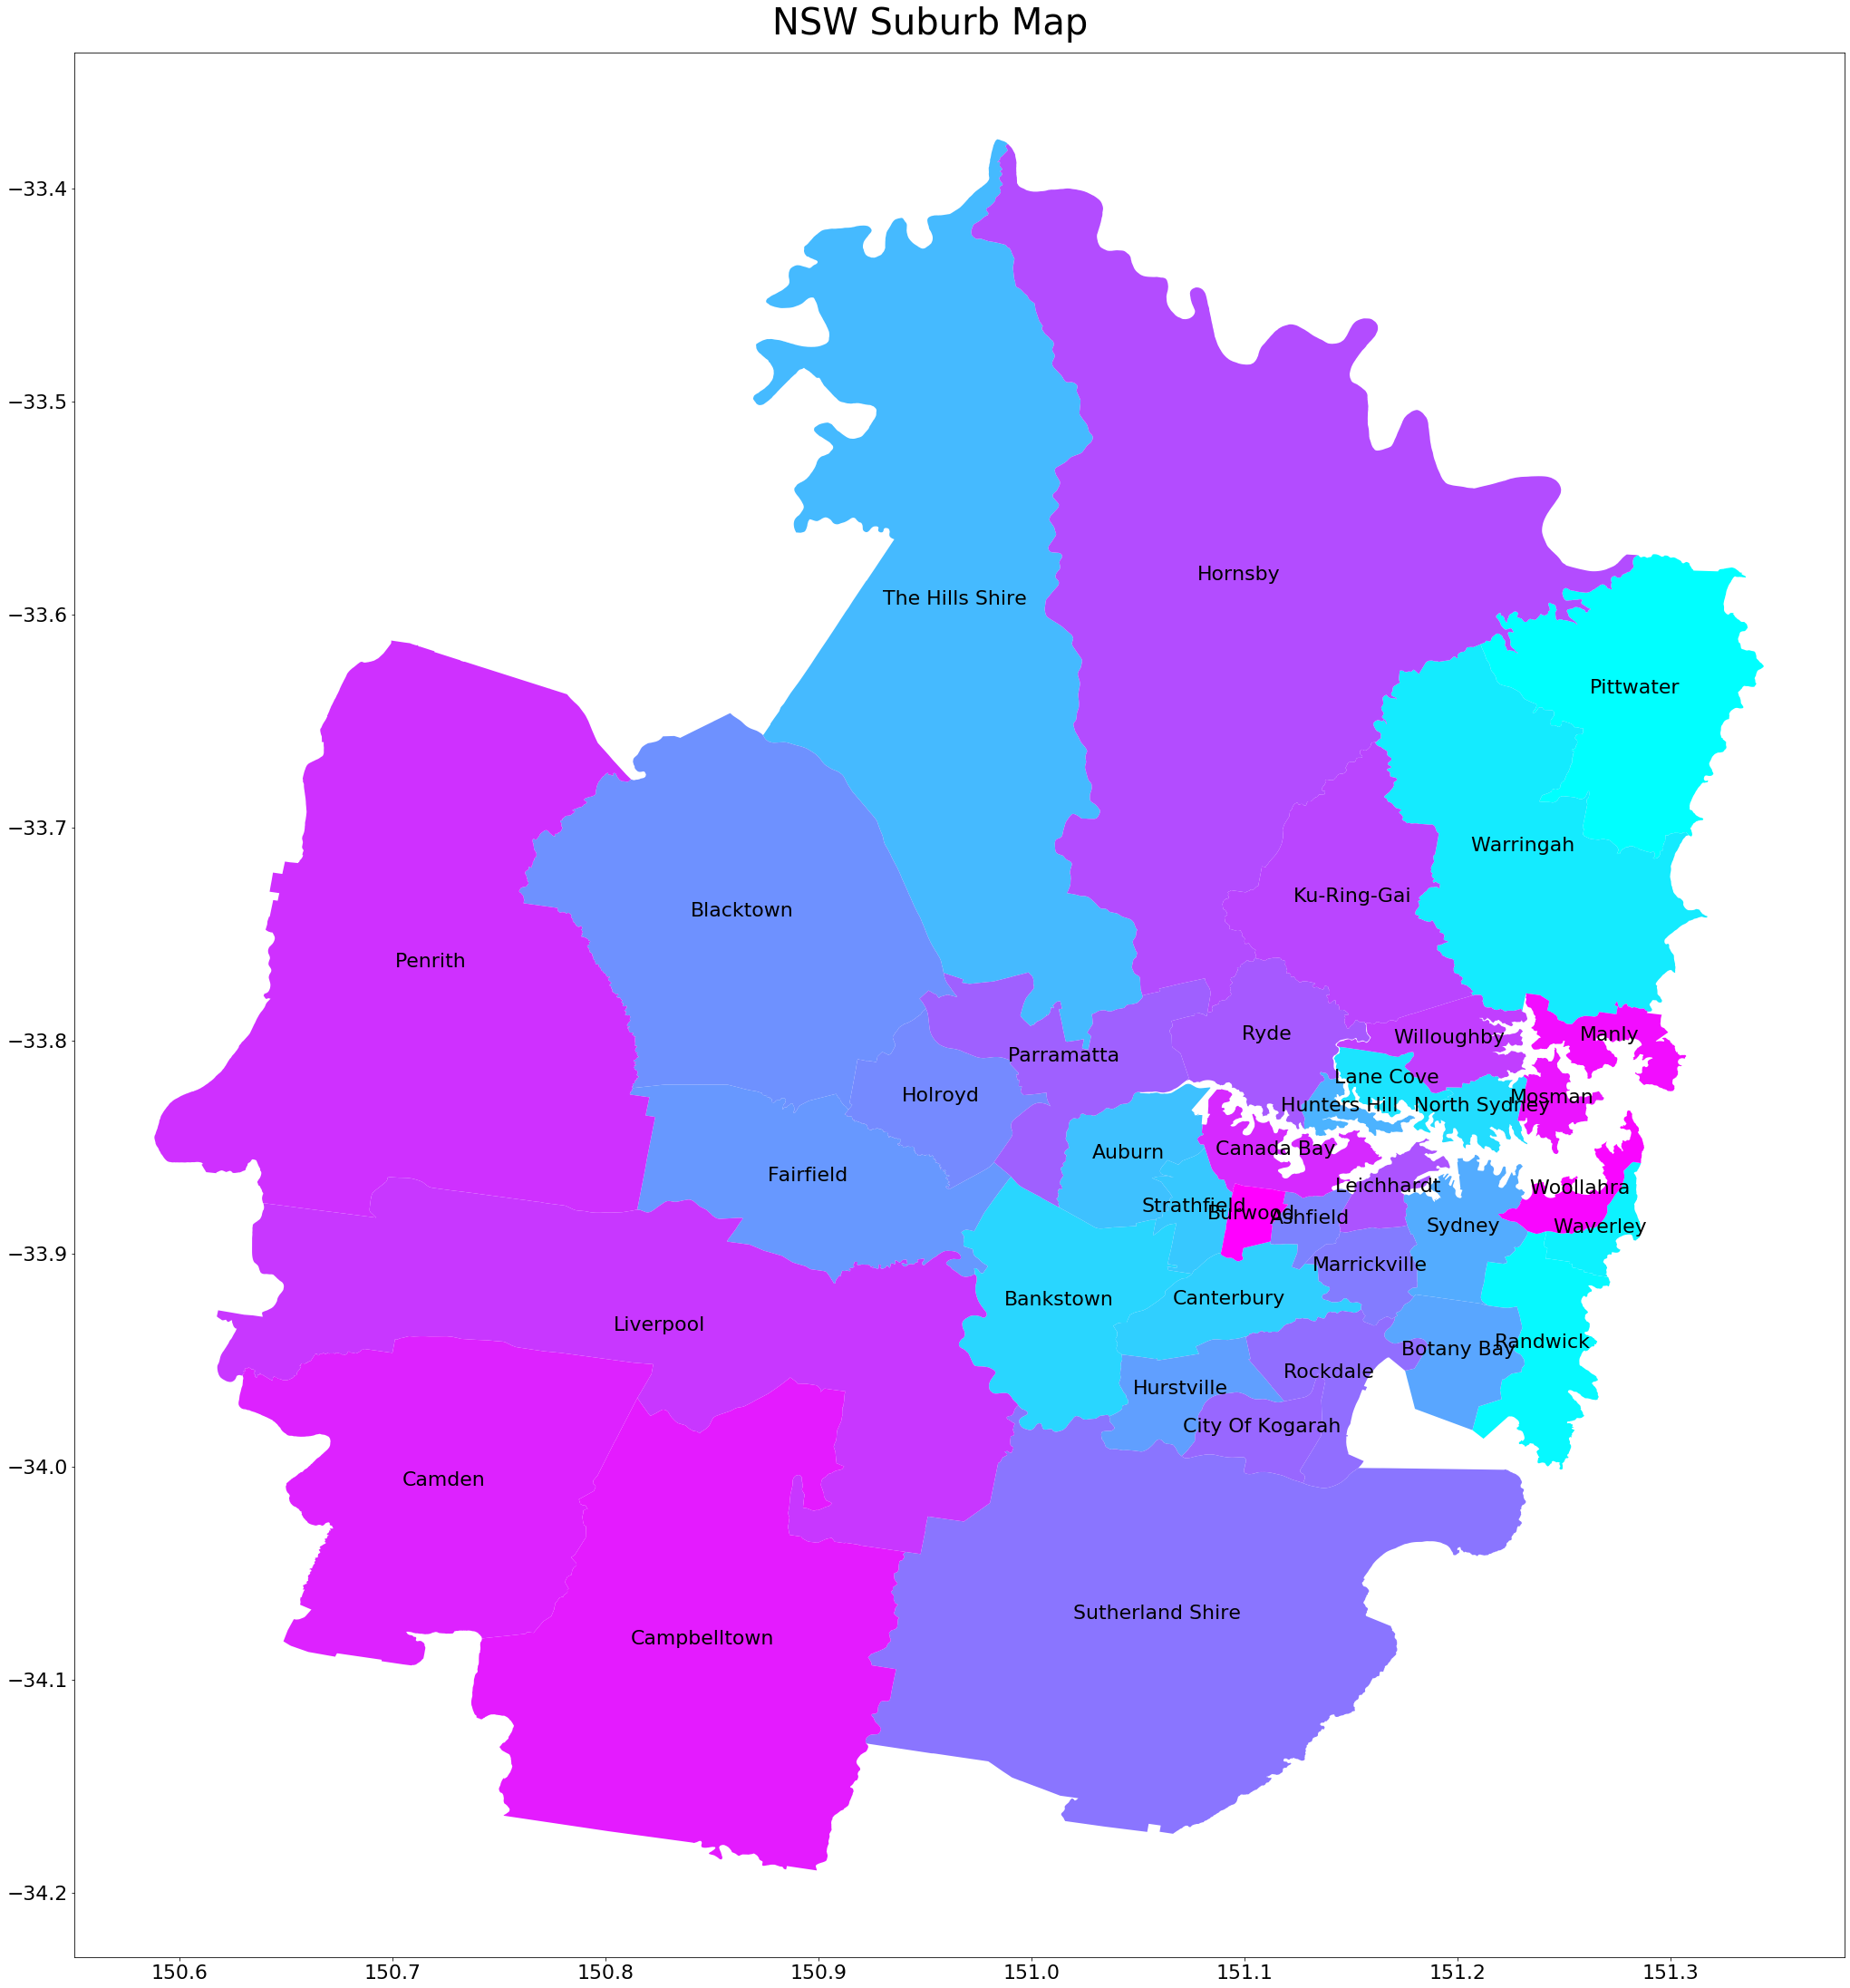

In [11]:
# Set centroid to print location name later
suburbs["centroid"] = suburbs.apply(add_centroid, axis=1)

# Update listings with geometry column for plotting purposes
listings = newGeometry(listings)

# Converts listings DataFrame into Geopanda DataFrame and store it in geo_listings
# geo_listings stores geometry information of available air_bnb rental locations
geo_listings = gp.GeoDataFrame(listings)

# Plot Map
suburbs.plot(cmap="cool")

# Prints suburb name
for idx, row in suburbs.iterrows():
    plt.annotate(s=row.neighbourhood, xy=tuple(row.centroid.coords)[0], 
                 horizontalalignment='center')
    
plt.figtext(.5,0.8,"NSW Suburb Map",fontsize=40,ha='center')

Plots all available AirBnb Rental Locations

Text(0.5, 0.85, 'Available AirBnb Rentals in NSW')

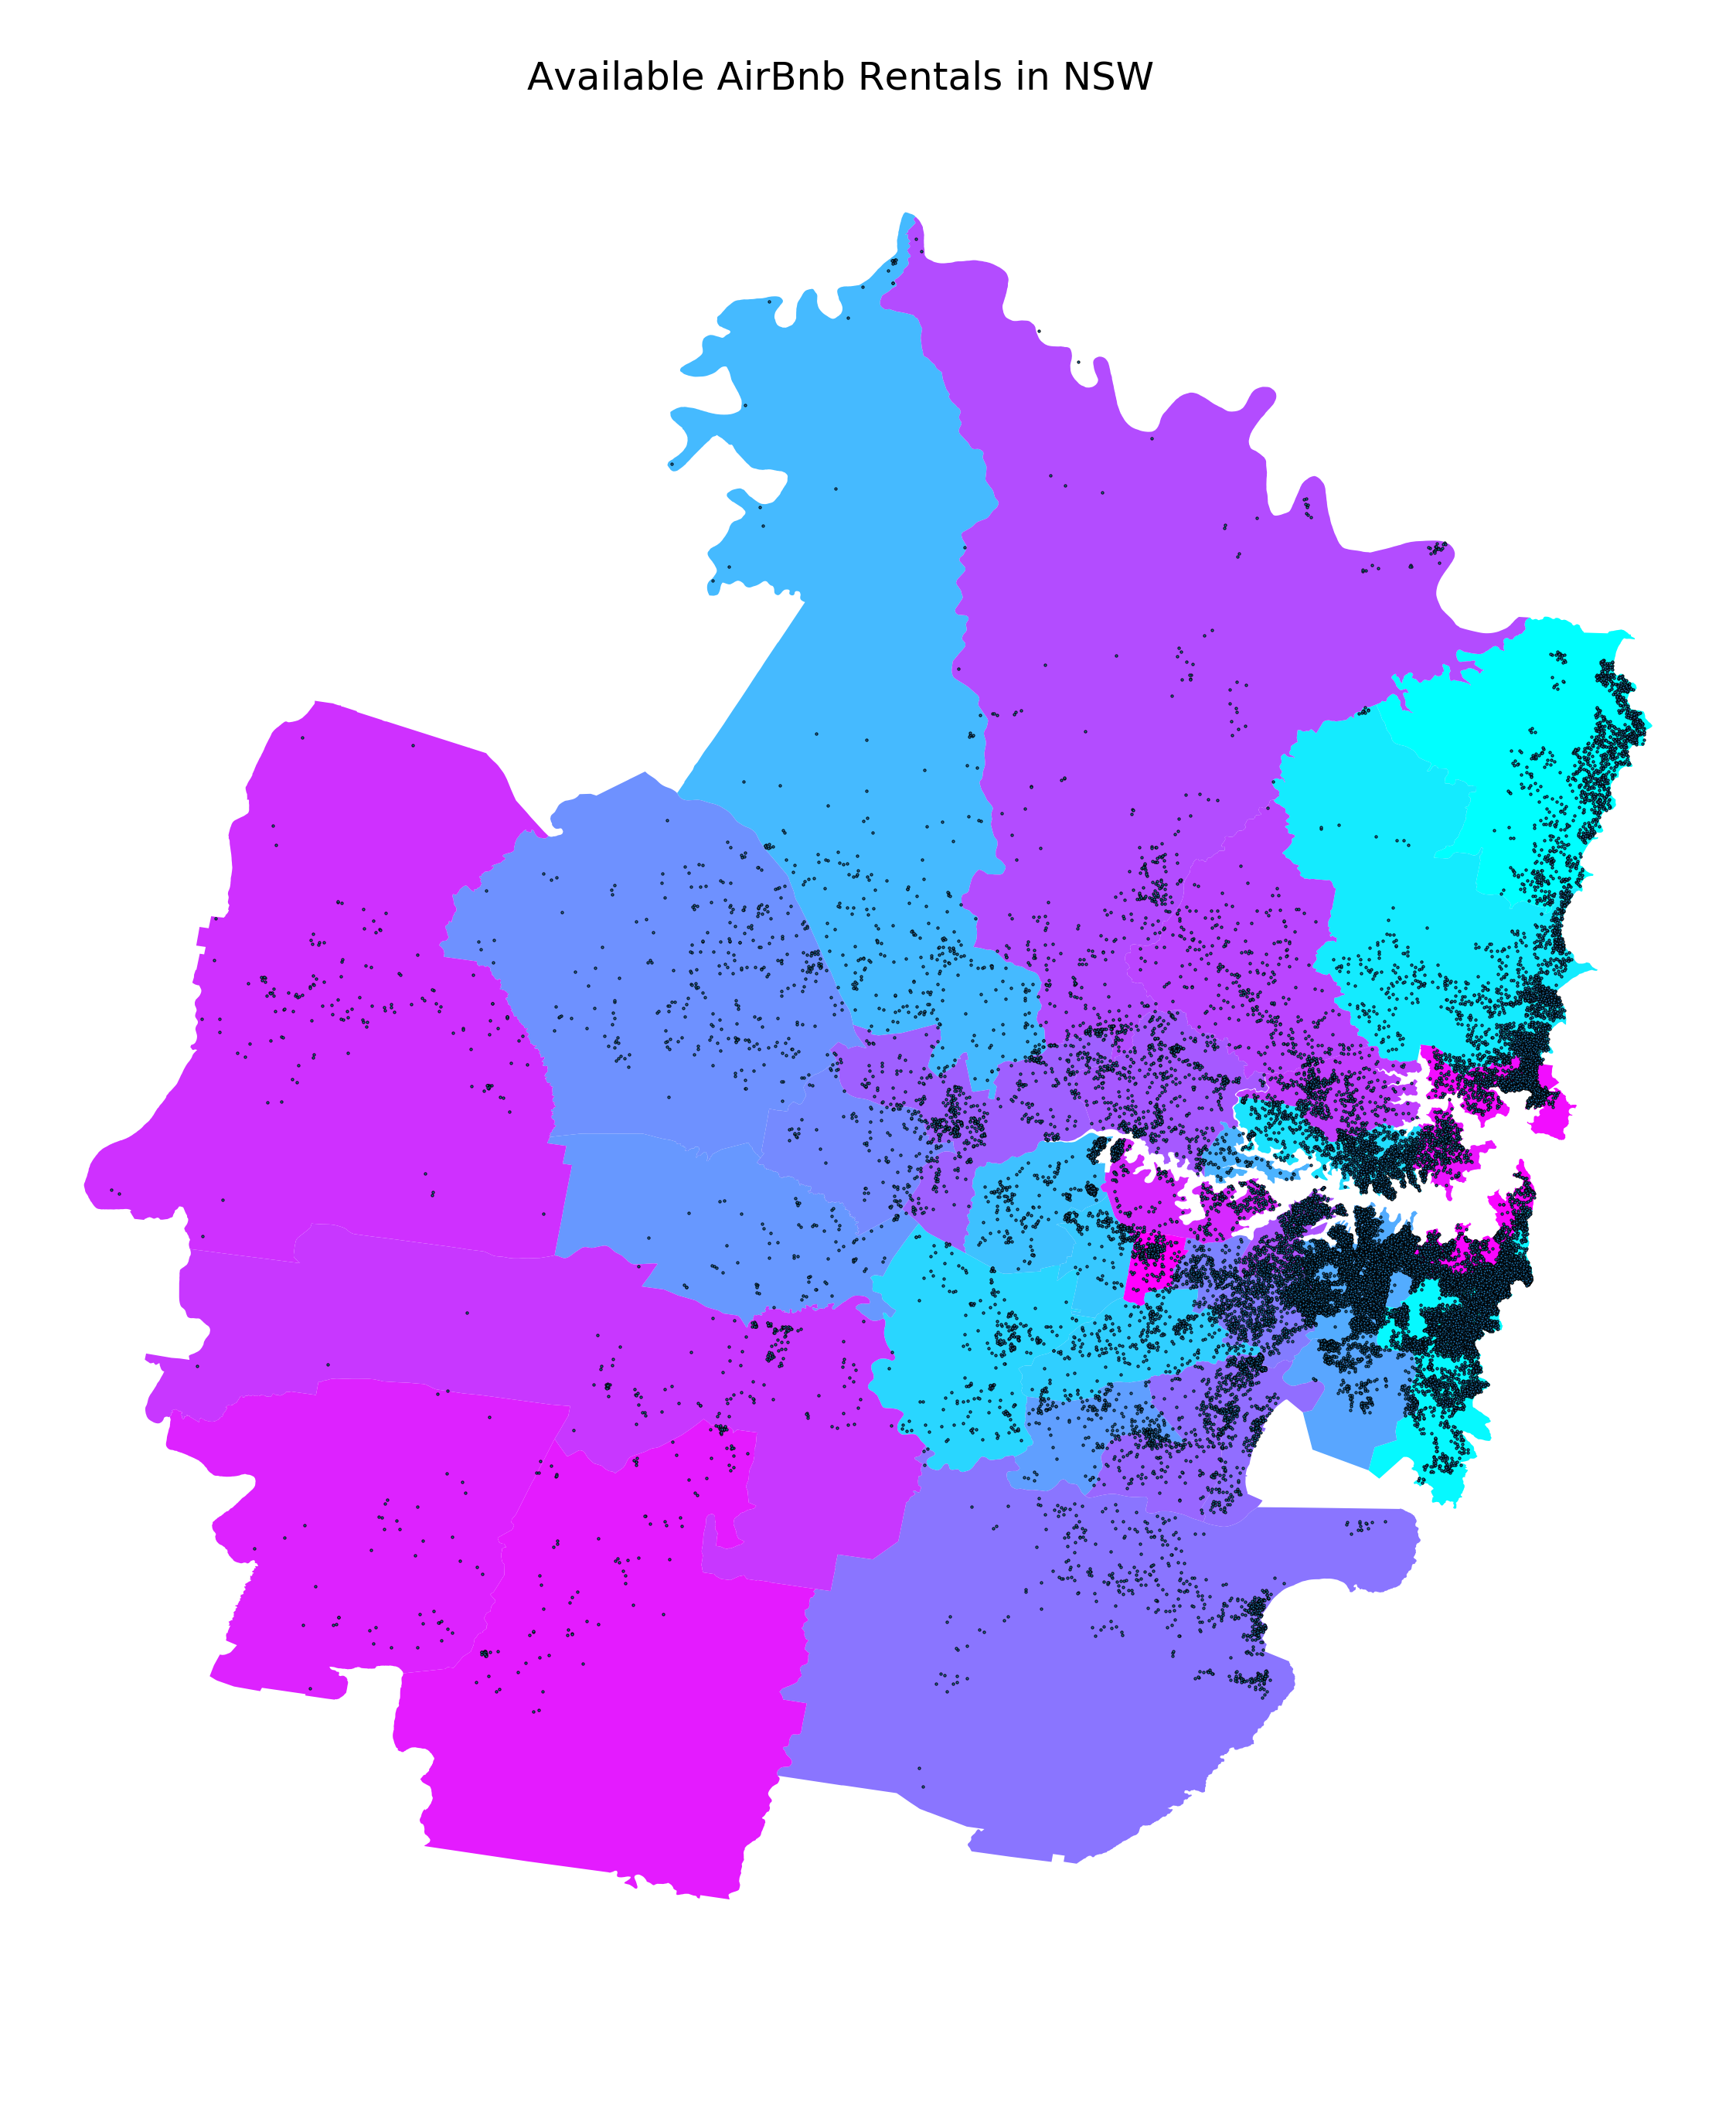

In [12]:
# IMPORTANT SETUP to ensure we are able to plot two DataFrame in the same graph
f, ax = plt.subplots(1, figsize=(40, 50))
ax.set_axis_off()
plt.axis('equal')
suburbs.plot(ax=ax, cmap='cool', linewidth=0.5)
geo_listings.plot(markersize=10, categorical=True, legend=True, ax=ax, edgecolor='black');

plt.figtext(.5,.85,"Available AirBnb Rentals in NSW",fontsize=50,ha='center')

Graph to display Types of AirBnB Rentals

In [13]:
# Function to create a list of dictionaries containing
# different Room Type Rentals and the total count of each
# available room type and price
def createRoomList(main_data):
    
    # List to return, contains information for Room Types 
    rlist = []
    
    for x in range(len(main_data["room_type"])):
        
        if checkExistingRoom(main_data["room_type"][x], rlist) == 0:
            new_dict = {
                "rtype" : main_data["room_type"][x],
                "count" : 1
            }
            rlist.append(new_dict)
            
        else:
            rlist = addRoomCount(rlist, main_data["room_type"][x])
            
        
        
    return rlist


# Function to add room count to associated room type
def addRoomCount(rlist, rtype):
    for x in rlist:
        if x["rtype"] == rtype:
            x["count"] += 1
            
    return rlist


# Function to check whether a Room Type exist already in a given
# list (rlist in this case), if exist return 1 else return 0
def checkExistingRoom(rtype, rlist):
    
    # For list is empty
    if not rlist:
        return 0
    
    for x in rlist:
        if x["rtype"] == rtype:
            return 1
    
    return 0


([<matplotlib.axis.XTick at 0x7f4f69b27fd0>,
 <a list of 3 Text xticklabel objects>)

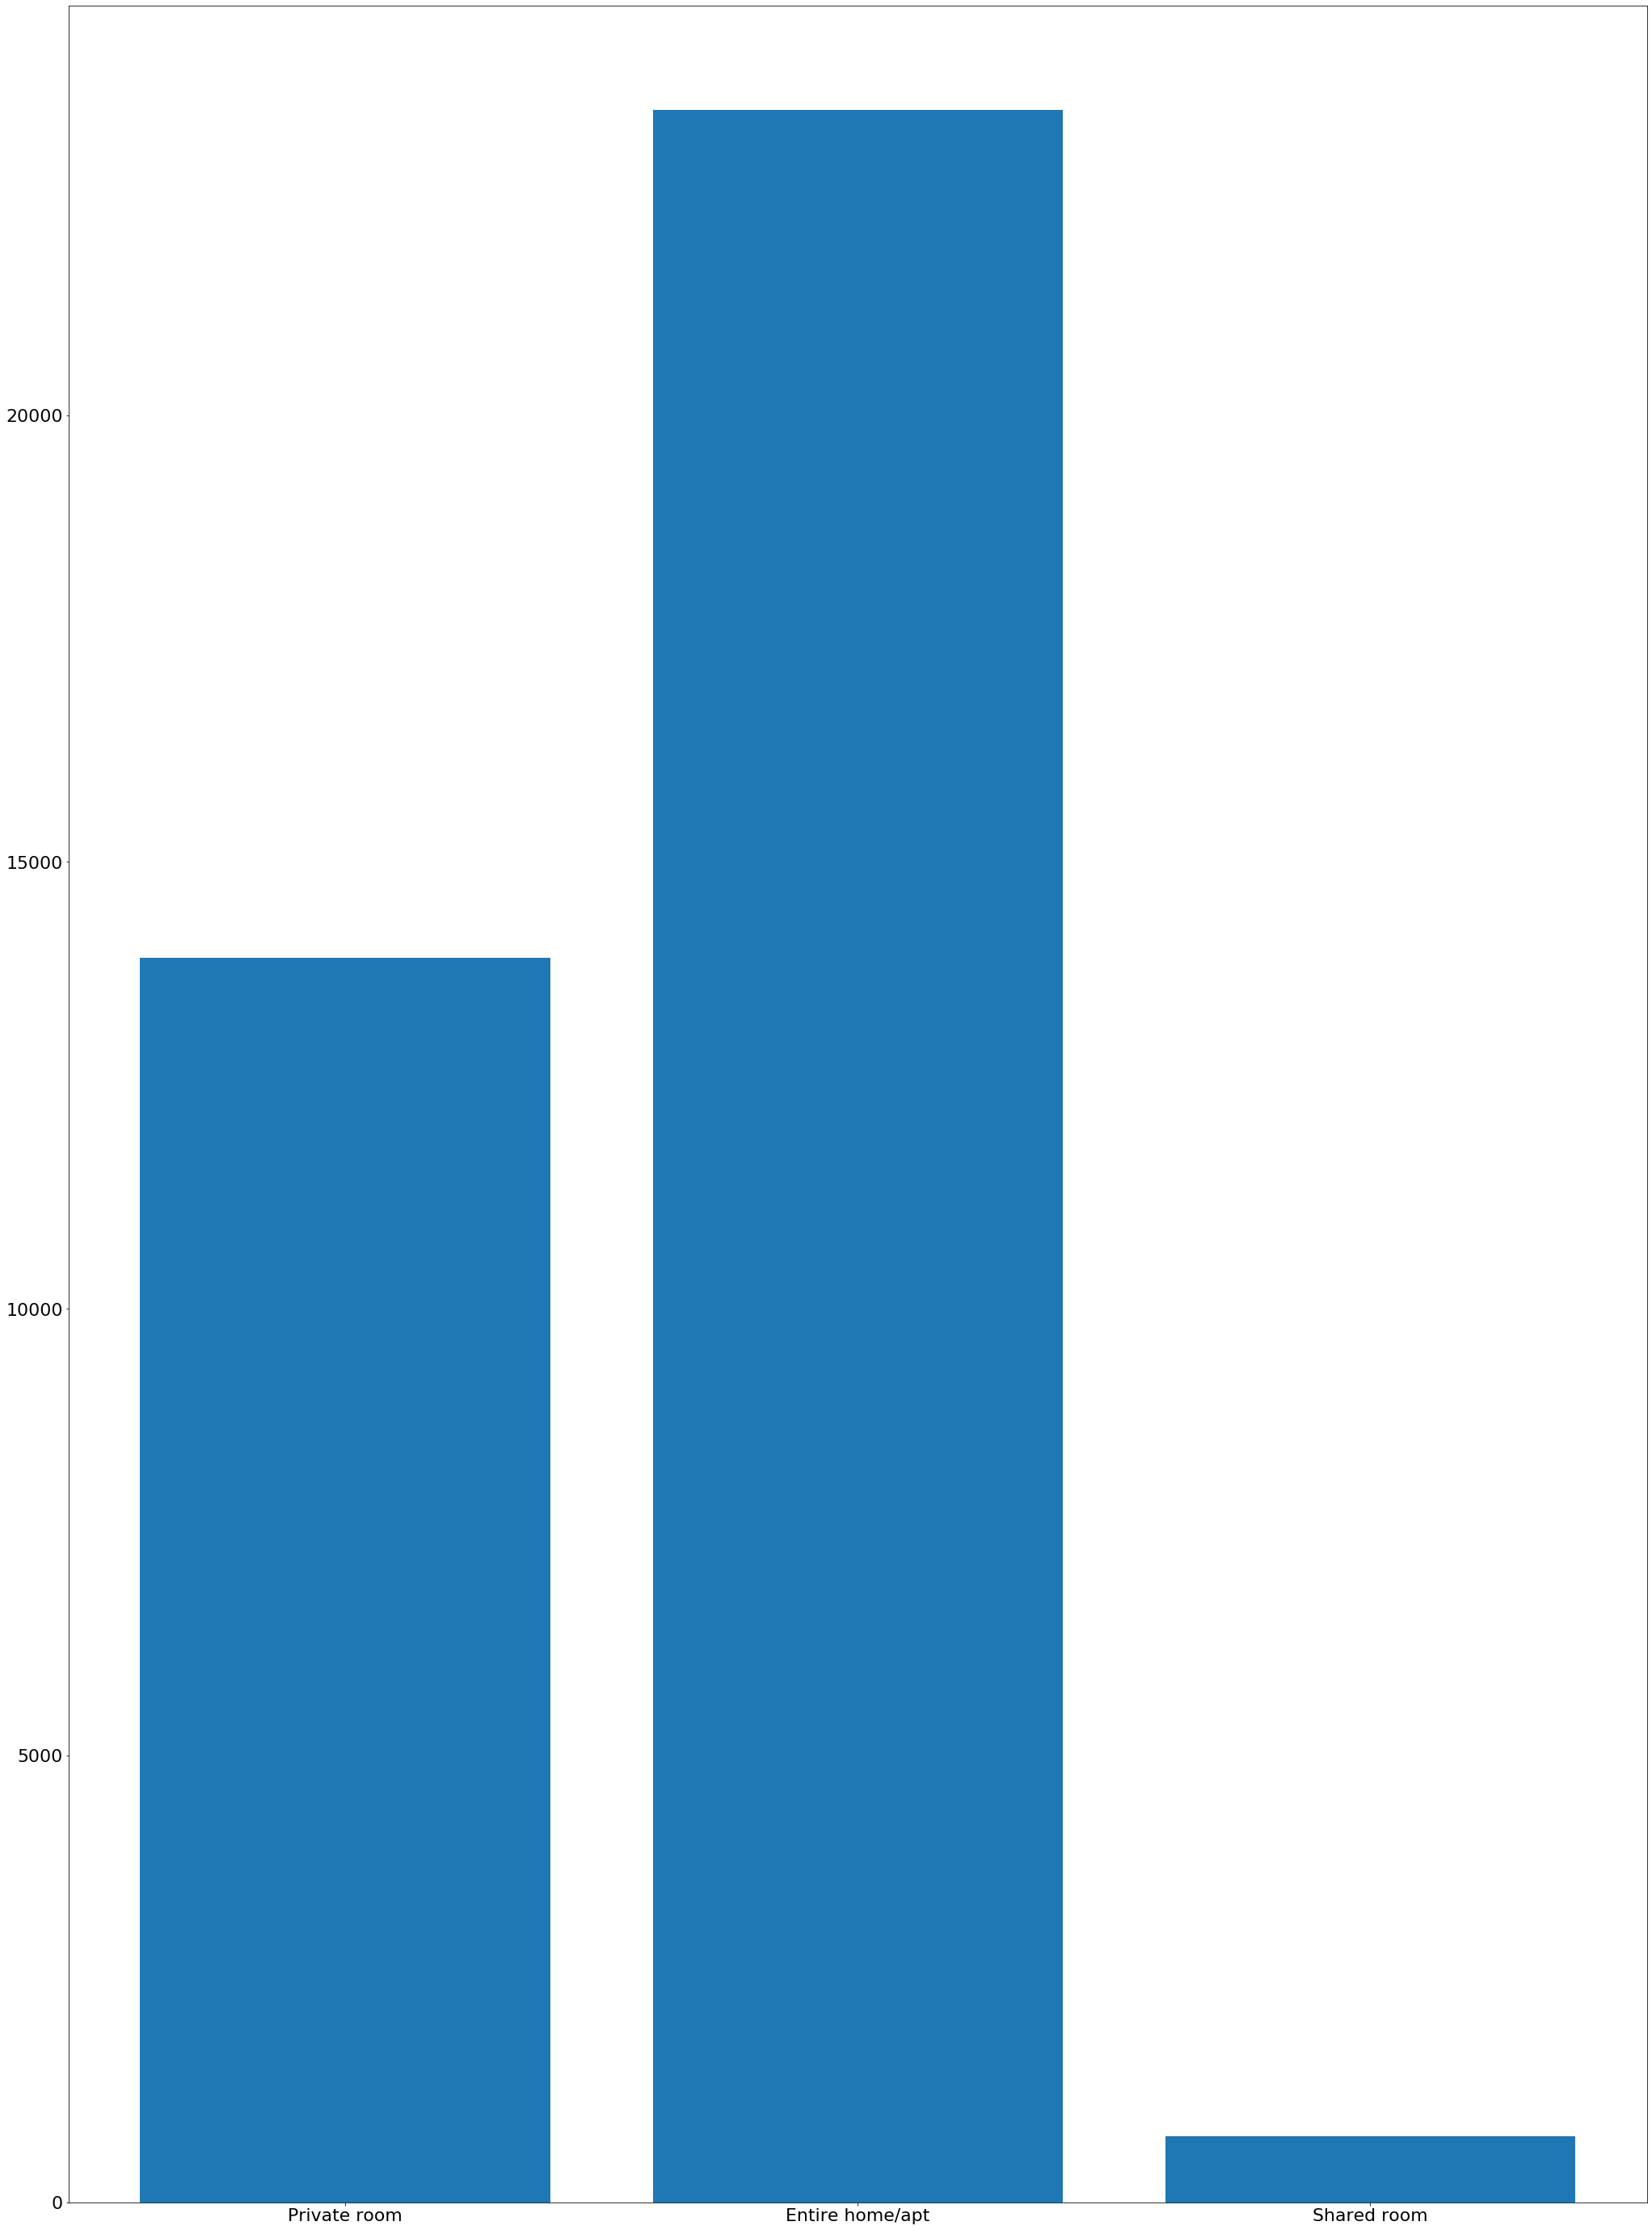

In [14]:
room_data = createRoomList(listings)
room_data = pd.DataFrame(room_data)

# numply plot stuff
# Set number of data points to plot with "nump"
nump_row = np.arange(len(room_data))
plt.bar(nump_row, room_data["count"])
plt.xticks(nump_row, room_data["rtype"])

Plot Avg Room Price for a Room Type & Associated Suburb

In [15]:
# Store all available room type into rt_list
rt_list = room_data["rtype"]

# Function to sot listings into suburbs associated with a room type
def sortSuburb(main_data, rt):
    
    rlist = []
    
    for x in range(len(main_data["room_type"])):

        if checkExistingSuburb(main_data["neighbourhood"][x], rlist) == 0 and main_data["room_type"][x] == rt:
            new_dict = {
                "location" : main_data["neighbourhood"][x],
                "price": round(main_data["price"][x]/main_data["minimum_nights"][x]),
                "count": 1,
                "rtype": main_data["room_type"][x]
            }
            
            rlist.append(new_dict)
        
        elif checkExistingSuburb(main_data["neighbourhood"][x], rlist) == 1 and main_data["room_type"][x] == rt:
            days = main_data["minimum_nights"][x]
            rlist = addSuburbCount(rlist, main_data["neighbourhood"][x], main_data["price"][x], days)
            
    rlist = avgPrice(rlist)
            
    return rlist


# Function to count average price for different suburbs & associated room type
def avgPrice(rlist):
    
    for x in rlist:
        x["price"] = round(x["price"] / x["count"])
            
    return rlist
    
    
# Function to add room count & price to associated room type
def addSuburbCount(rlist, suburb, price, days):
    
    daily_price = round(price/days)
    
    for x in rlist:
        if x["location"] == suburb:
            x["count"] += 1
            x["price"] += daily_price
            
    return rlist


# Function to check whether a Suburb exist already in a given
# list (rlist in this case), if exist return 1 else return 0
def checkExistingSuburb(loc, rlist):
    
    # For list is empty
    if not rlist:
        return 0
    
    for x in rlist:
        if x["location"] == loc:
            return 1
    
    return 0
    

In [16]:
tmp = sortSuburb(listings, rt_list[0])
print_data = pd.DataFrame(tmp)
print_data.rename(columns={"count": "Available Rooms", "location": "Location", "price": "Avg. Price per night", "rtype": "Room Type"}, inplace=True)
print_data

,Location,Avg. Price per night,Available Rooms,Room Type
0,Sydney,69.0,3210,Private room
1,Woollahra,54.0,527,Private room
2,Lane Cove,67.0,123,Private room
3,Marrickville,42.0,627,Private room
4,Hornsby,51.0,192,Private room
5,Waverley,47.0,1813,Private room
6,North Sydney,59.0,412,Private room
7,Sutherland Shire,67.0,150,Private room
8,Ku-Ring-Gai,59.0,154,Private room
9,Strathfield,47.0,110,Private room


<Figure size 720x720 with 0 Axes>

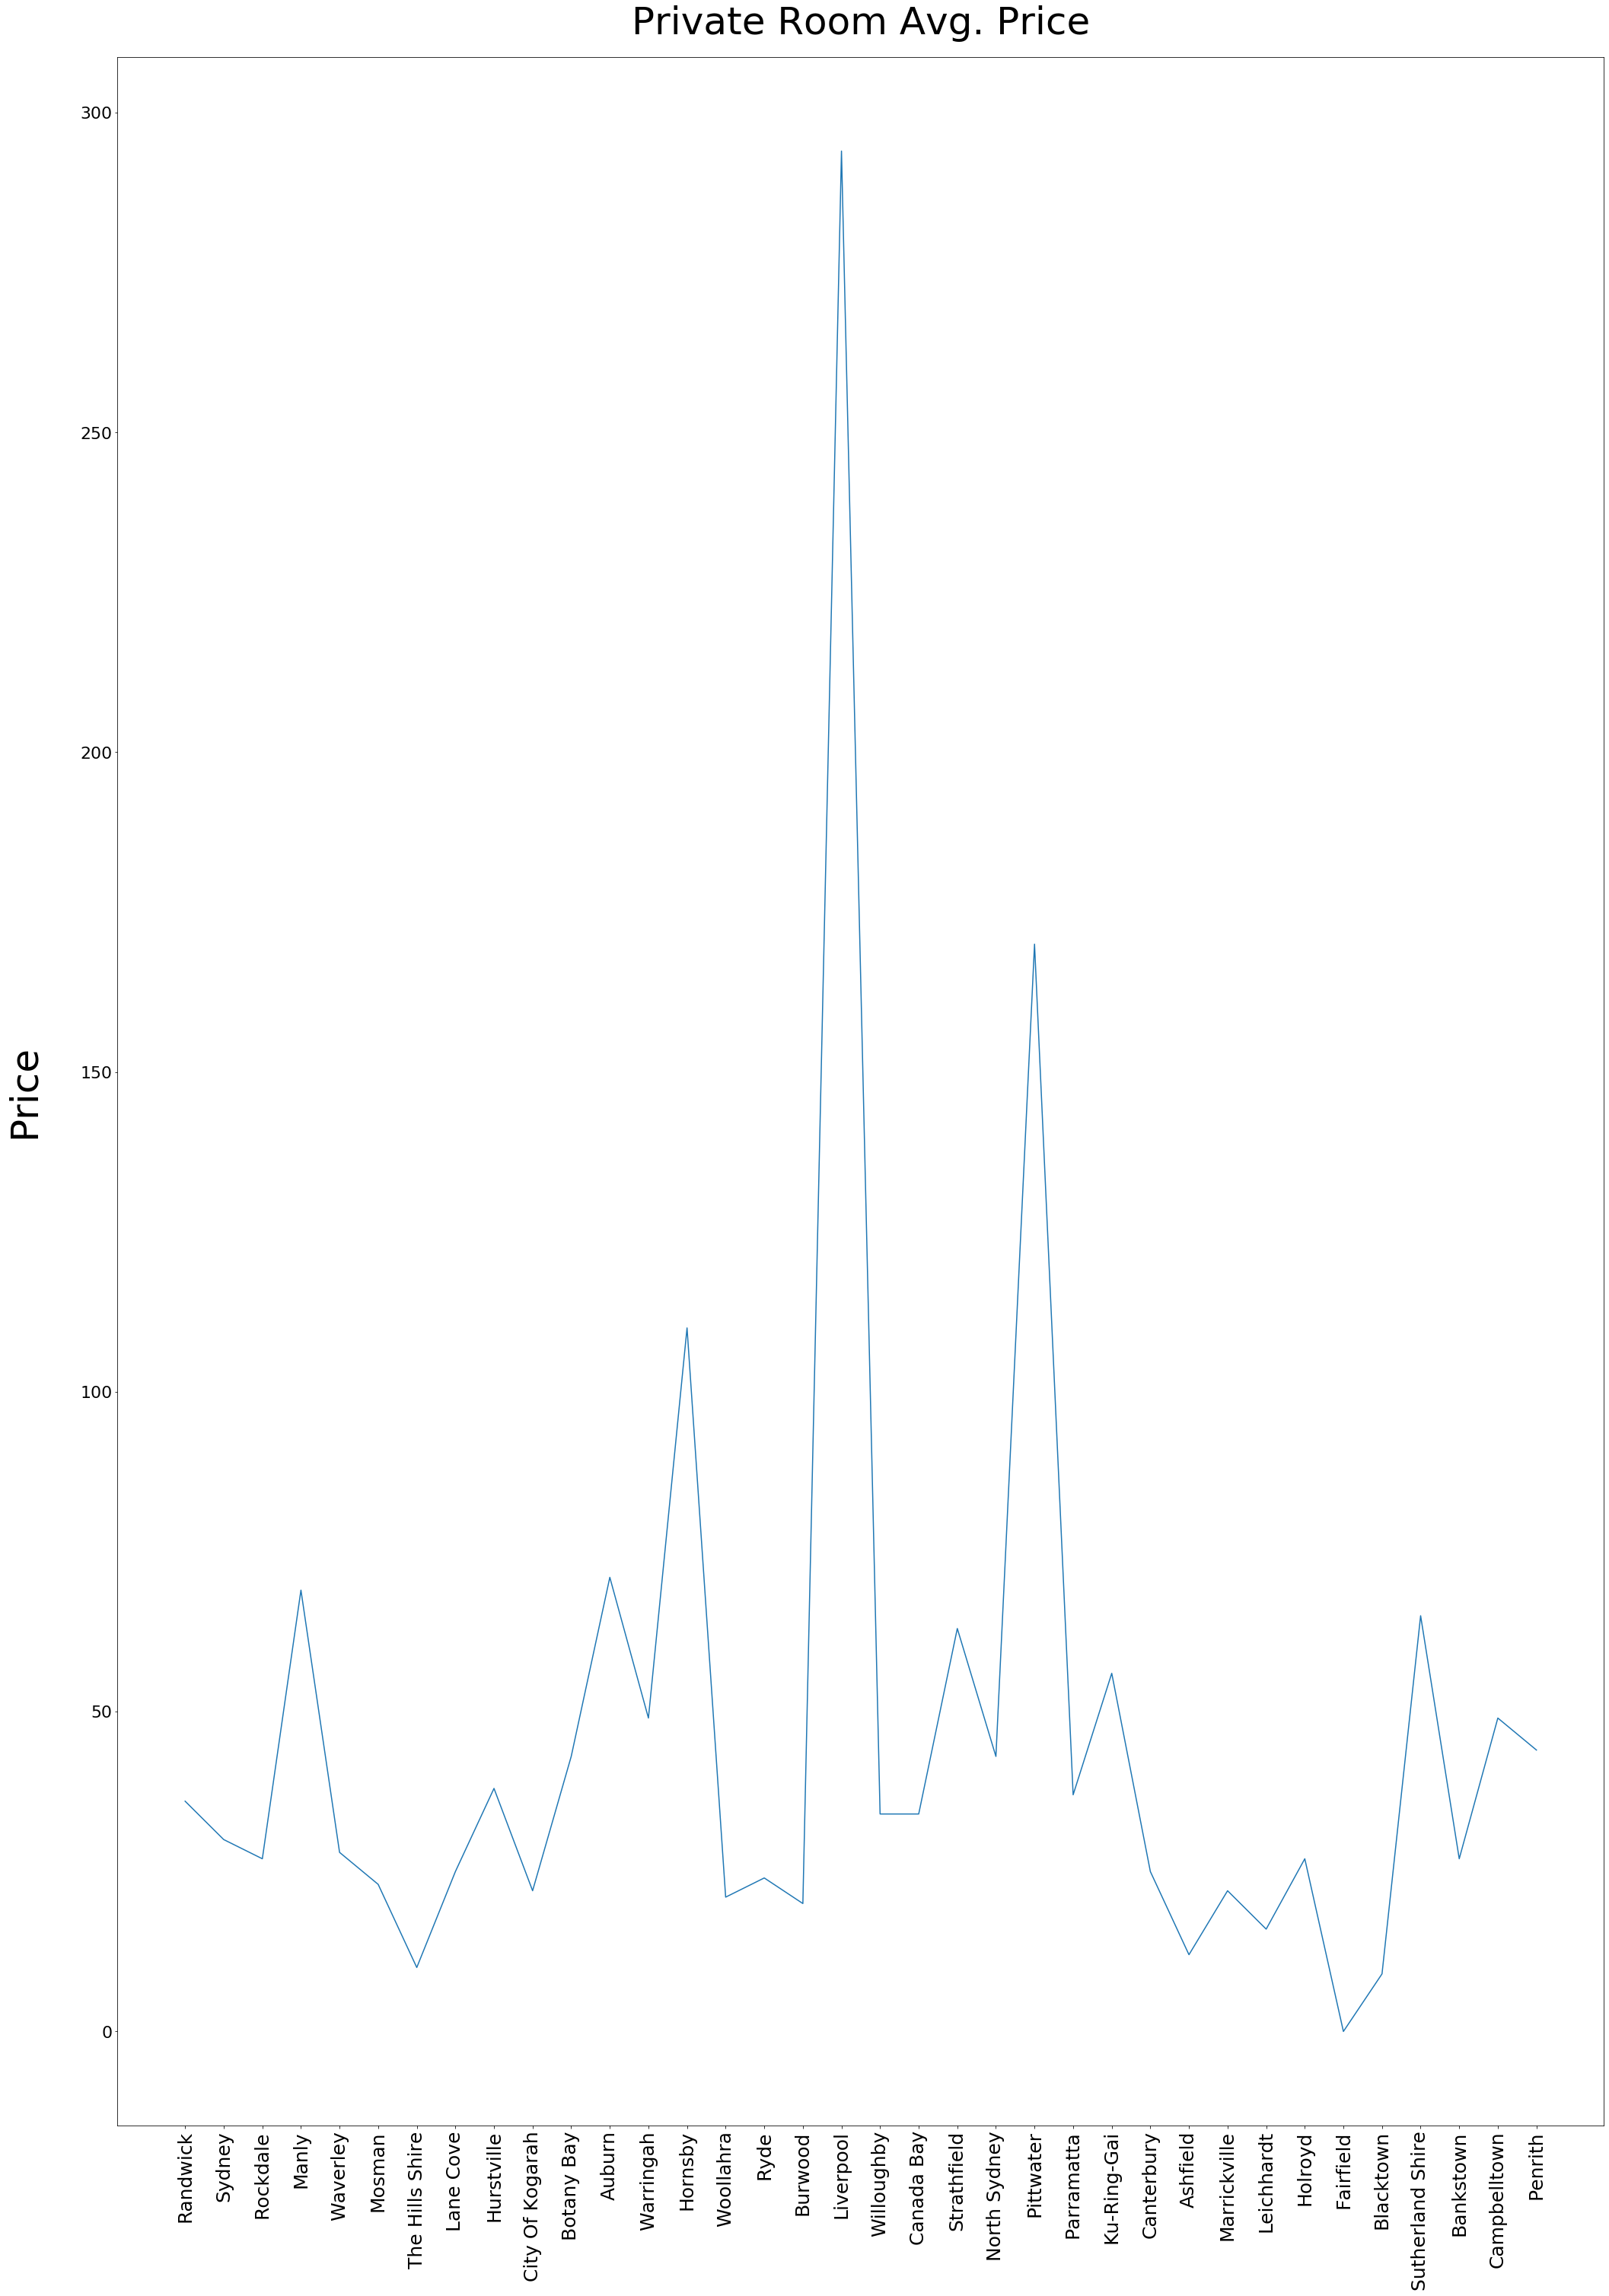

<Figure size 720x720 with 0 Axes>

In [79]:
# Plotting avg_cost_data on a graph
plot_data = pd.DataFrame(tmp)
plot_data
plt.plot(plot_data["location"], plot_data["price"])
plt.xticks(plot_data["location"], rotation='vertical', fontsize=25)
plt.ylabel("Price", fontsize=50, labelpad=50)
plt.title("Private Room Avg. Price", fontsize=50, pad=30)
plt.figure(figsize=(10,10))


In [18]:
tmp = sortSuburb(listings, rt_list[1])
print_data = pd.DataFrame(tmp)
print_data.rename(columns={"count": "Available Rooms", "location": "Location", "price": "Avg. Price per night", "rtype": "Room Type"}, inplace=True)
print_data

,Location,Avg. Price per night,Available Rooms,Room Type
0,Manly,103.0,1363,Entire home/apt
1,Leichhardt,107.0,683,Entire home/apt
2,North Sydney,91.0,986,Entire home/apt
3,Waverley,110.0,3507,Entire home/apt
4,Sydney,111.0,6235,Entire home/apt
5,Mosman,118.0,415,Entire home/apt
6,Pittwater,204.0,1051,Entire home/apt
7,Warringah,89.0,1358,Entire home/apt
8,Rockdale,104.0,330,Entire home/apt
9,Randwick,94.0,1921,Entire home/apt


<Figure size 720x720 with 0 Axes>

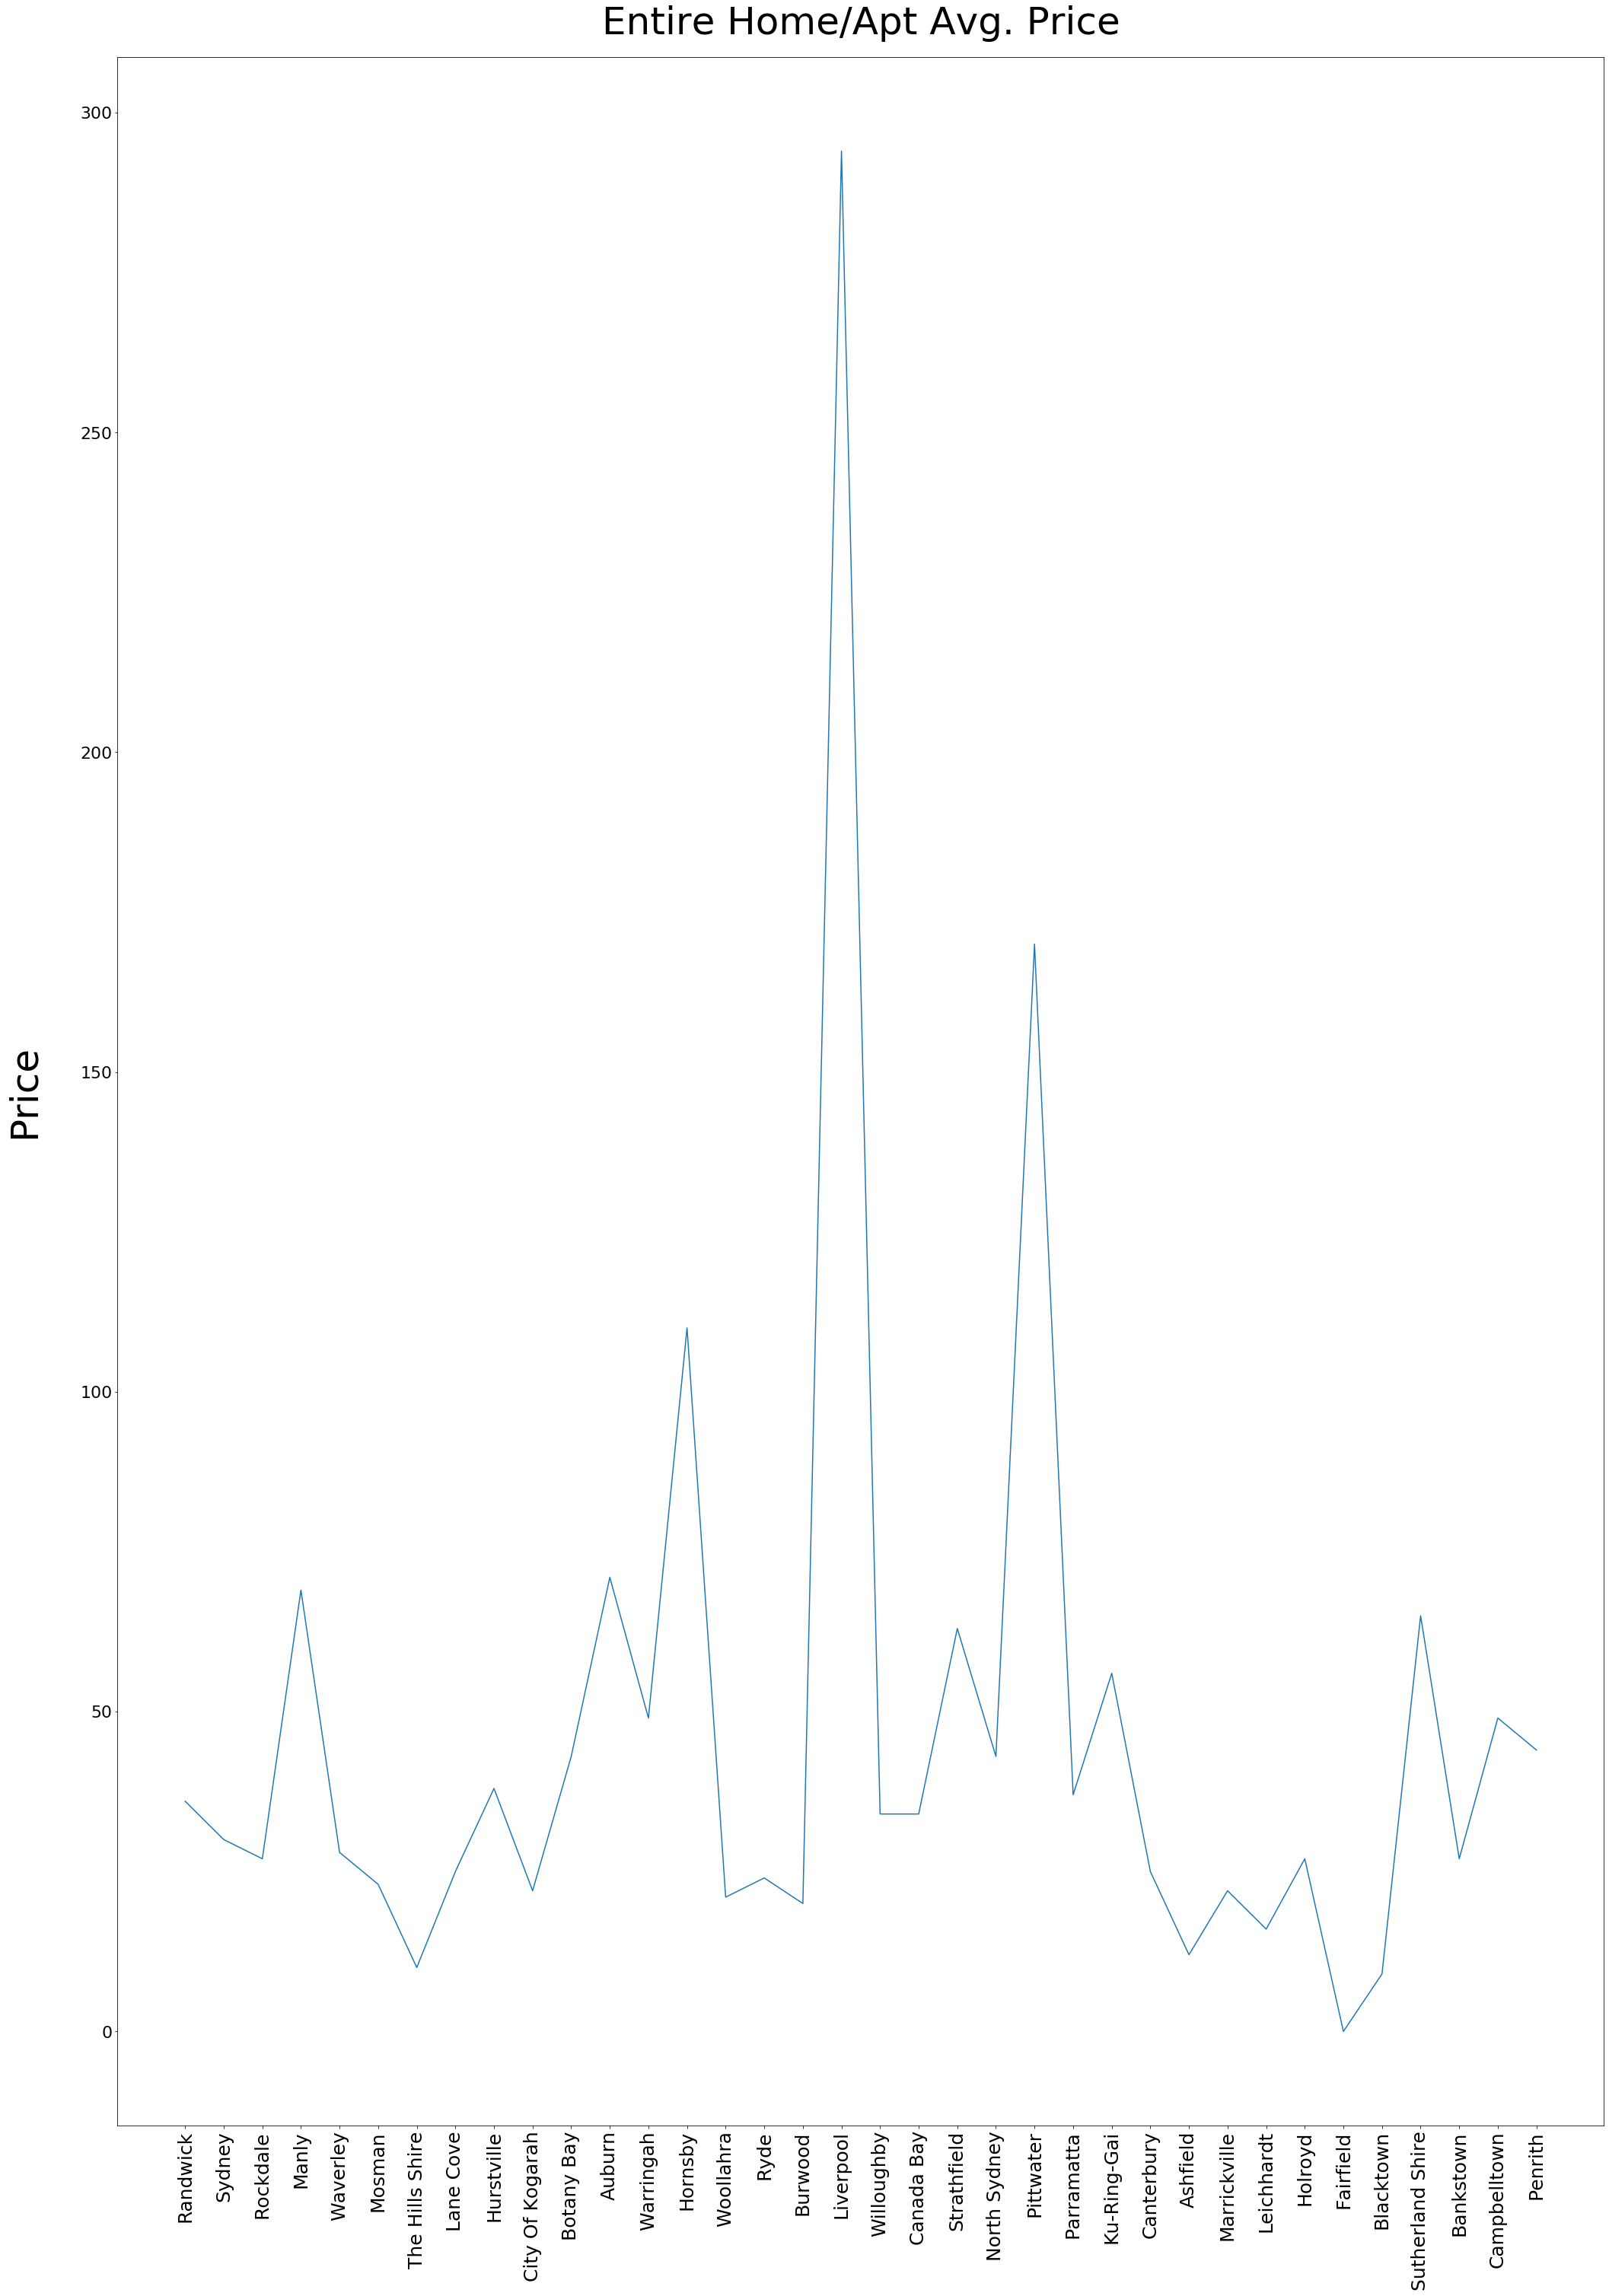

<Figure size 720x720 with 0 Axes>

In [84]:
# Plotting avg_cost_data on a graph
plot_data = pd.DataFrame(tmp)
plot_data
plt.plot(plot_data["location"], plot_data["price"])
plt.xticks(plot_data["location"], rotation='vertical', fontsize=25)
plt.ylabel("Price", fontsize=50, labelpad=50)
plt.title("Entire Home/Apt Avg. Price", fontsize=50, pad=30)
plt.figure(figsize=(10,10))

In [20]:
tmp = sortSuburb(listings, rt_list[2])
print_data = pd.DataFrame(tmp)
print_data.rename(columns={"count": "Available Rooms", "location": "Location", "price": "Avg. Price per night", "rtype": "Room Type"}, inplace=True)
print_data

,Location,Avg. Price per night,Available Rooms,Room Type
0,Randwick,36.0,65,Shared room
1,Sydney,30.0,301,Shared room
2,Rockdale,27.0,17,Shared room
3,Manly,69.0,9,Shared room
4,Waverley,28.0,118,Shared room
5,Mosman,23.0,2,Shared room
6,The Hills Shire,10.0,1,Shared room
7,Lane Cove,25.0,6,Shared room
8,Hurstville,38.0,6,Shared room
9,City Of Kogarah,22.0,4,Shared room


<Figure size 1440x720 with 0 Axes>

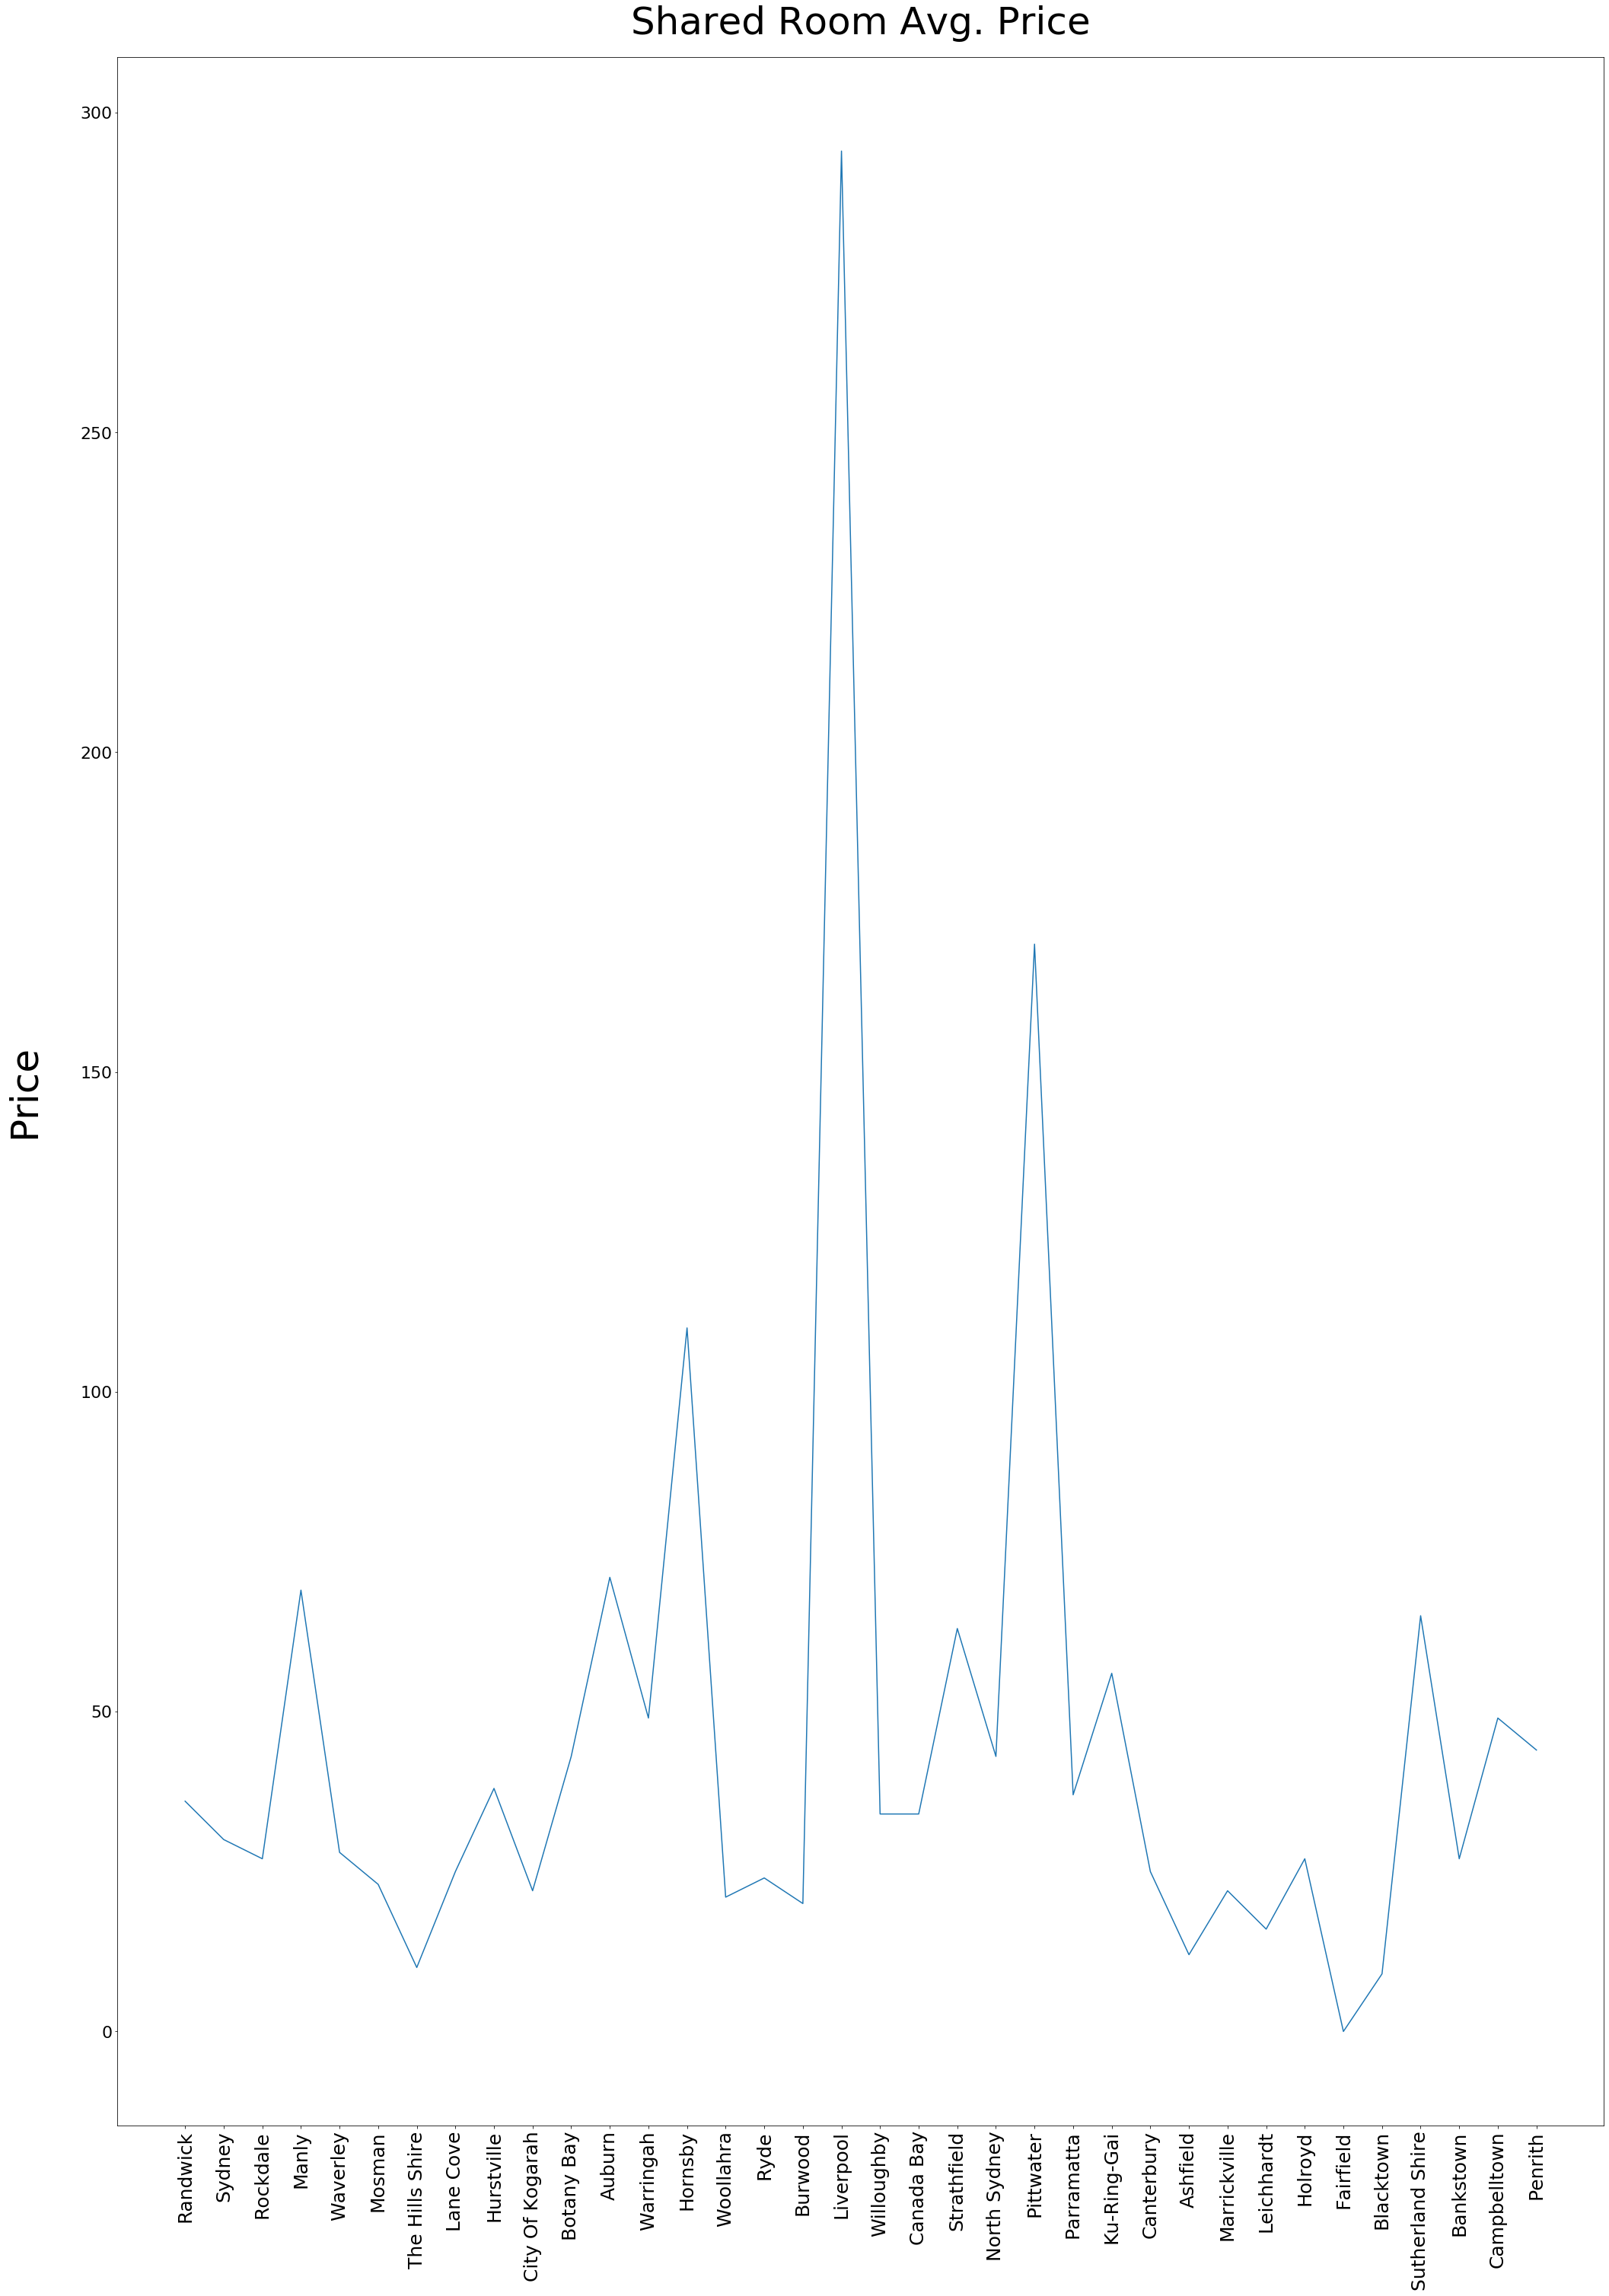

<Figure size 1440x720 with 0 Axes>

In [70]:
# Plotting avg_cost_data on a graph
plot_data = pd.DataFrame(tmp)
plot_data
plt.plot(plot_data["location"], plot_data["price"])
plt.xticks(plot_data["location"], rotation='vertical', fontsize=25)
plt.ylabel("Price", fontsize=50, labelpad=50)
plt.title("Shared Room Avg. Price", fontsize=50, pad=30)
plt.figure(figsize=(20,10))


Gets list of most recent reviews

In [44]:
# Function to get the most recent rental of (2018-2019)
# Returns a list of id's & associated geo data
def getRecentLocation(main_data, year):
    
    output = []
    maxLen = len(main_data["last_review"])
    
    for x in range(maxLen):
        
        #Check if date_str is not NULL object, if NULL continue
        if isinstance(main_data["last_review"][x], str) != True: 
            continue
        
        if compareDates(main_data["last_review"][x], year) == 1:
            new_dict = {
                "id" : main_data["id"][x],
                "geometry" : main_data["geometry"][x],
                "date" : main_data["last_review"][x]
            }
            output.append(new_dict)
            
    return output
        

# Function to check if given date is within the different holiday dates (Long holidays)
# If within the holiday dates return 1, else return 0
def compareDates(date_str, year):
    
    # Converts string into date type
    new_date = datetime.strptime(date_str, "%Y-%m-%d")
    
    # Calls a function to create holidays start and end dates
    # hlist[0] returns list of holidays start date & hlist[1] returns list of holidays 
    # end date
    hlist = createHolidays(year)
    
    holiday_start = hlist[0]
    holiday_end = hlist[1]
    
    # If statements with all the different holiday dates
    for i in range(len(holiday_start)):
        
        if new_date >= holiday_start[i] and new_date <= holiday_end[i]:
            return 1

    return 0


# Function to create a list of holidays
def createHolidays(year):
    
    # Main List to return, stores two list 
    res = [] 
    
    holiday_start = []
    holiday_end = []
    
    # Setup for different holidays
    t1_start = datetime(year, 4, 13)
    holiday_start.append(t1_start)
    
    t1_end = datetime(year, 4, 28)
    holiday_end.append(t1_end)
    
    t2_start = datetime(year, 7, 6)
    holiday_start.append(t2_start)
    
    t2_end = datetime(year, 7, 21)
    holiday_end.append(t2_end)
    
    t3_start = datetime(year, 9, 28)
    holiday_start.append(t3_start)
    
    t3_end = datetime(year, 10, 13)
    holiday_end.append(t3_end)
    
    t4_start = datetime(year, 12, 19)
    holiday_start.append(t4_start)
    
    t4_end = datetime(year+1, 2, 2) # Special case for the one to read the next year
    holiday_end.append(t4_end)
    
    res.append(holiday_start)
    res.append(holiday_end)
    
    return res


Text(0.5, 0.85, 'Holiday Rentals Location, April 2018 - Feb 2019')

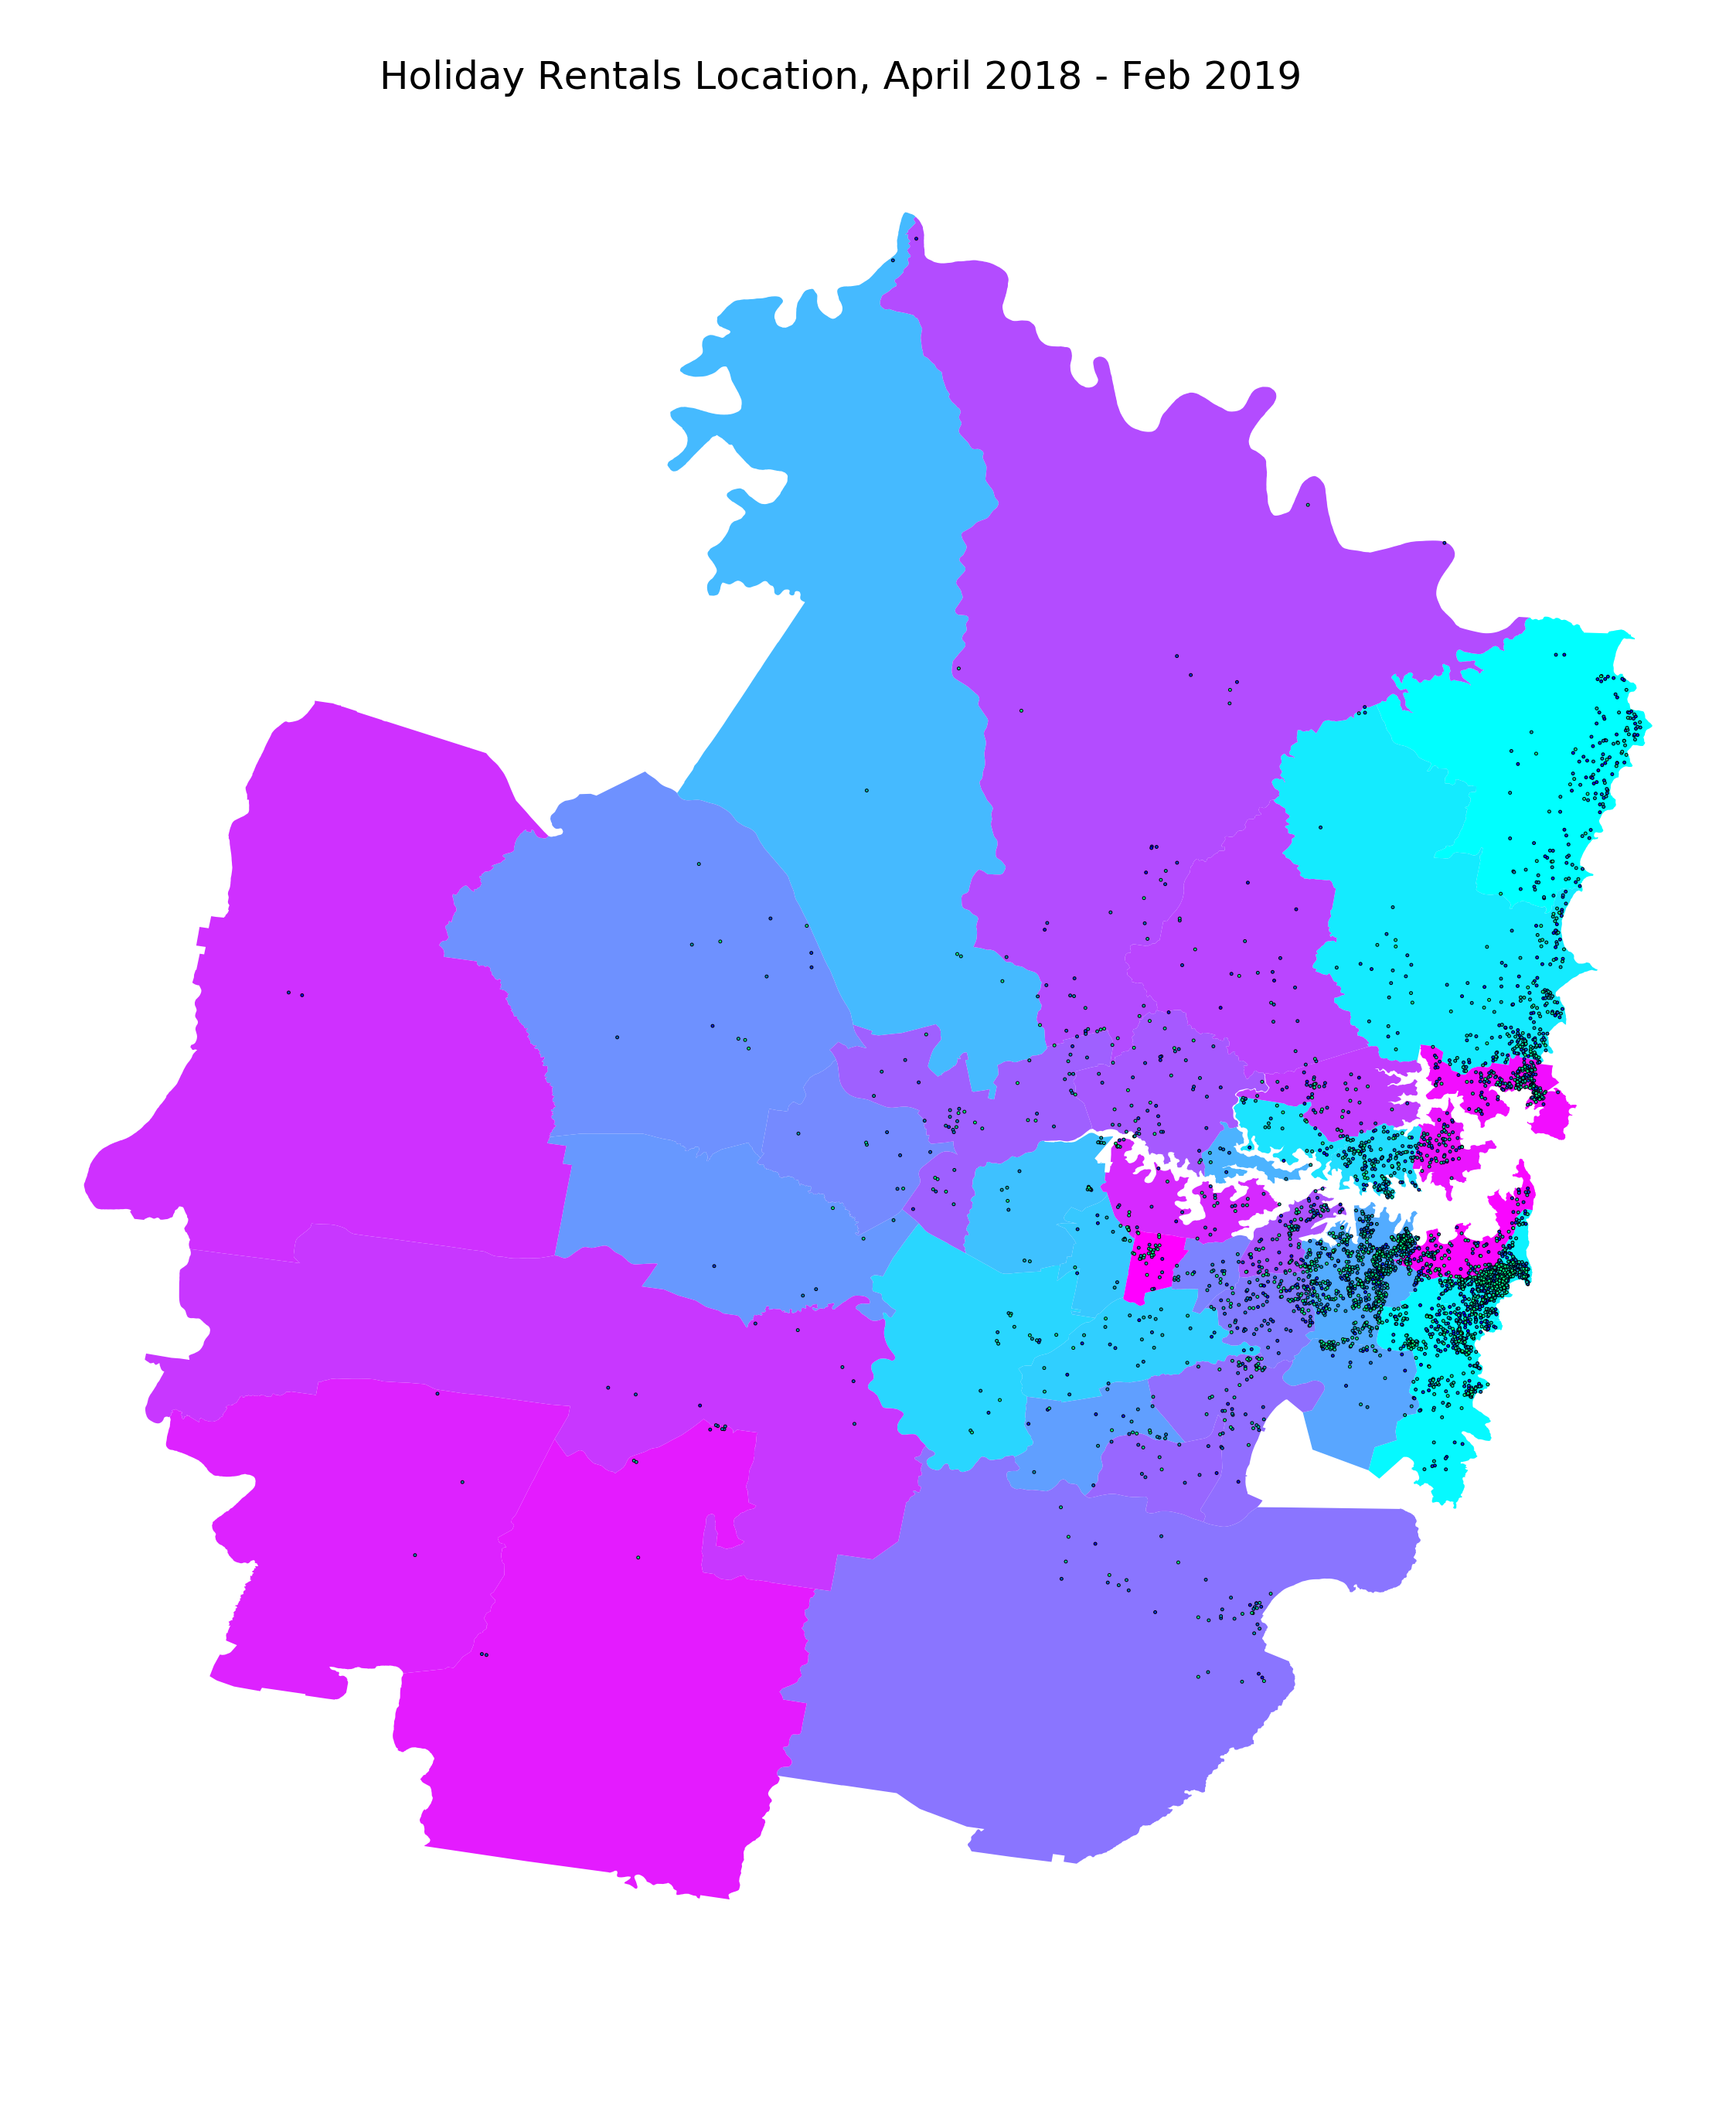

In [73]:
# Get information for recent reviews
recent_id = getRecentLocation(listings, 2018)
recent_id = pd.DataFrame(recent_id)
recent_geo = gp.GeoDataFrame(recent_id) # Convert recent_id into geopanda data frame

# IMPORTANT SETUP to ensure we are able to plot two DataFrame in the same graph
f, ax = plt.subplots(1, figsize=(40, 50))
ax.set_axis_off()
plt.axis('equal')
suburbs.plot(ax=ax, cmap='cool', linewidth=0.5)
recent_geo.plot(markersize=15, categorical=True, legend=True, ax=ax, cmap="winter",edgecolor='black');

plt.figtext(.5,.85,"Holiday Rentals Location, April 2018 - Feb 2019",fontsize=50,ha='center')

Make bar graph showing places with highest rent count